# Reinforcement Learning Programming - CSCN 8020

## Assignment 1

### Exercise 4

### Done by ***Eris Leksi***

Problem 4 [35]

Problem Statement:

Off-policy Monte Carlo with Importance Sampling: We will use the same environment, states,
actions, and rewards in Problem 3.

Task

Implement the off-policy Monte Carlo with Importance sampling algorithm to estimate the value
function for the given gridworld. Use a fixed behavior policy b(a|s) (e.g., a random policy) to generate
episodes and a greedy target policy.

Suggested steps

1. Generate multiple episodes using the behavior policy b(a|s).

2. For each episode, calculate the returns (sum of discounted rewards) for each state.

3. Use importance sampling to estimate the value function and update the target policy π(a|s).

4. You can assume a specific discount factor (e.g., γ = 0.9) for this problem.

5. Use the same main algorithm implemented in lecture 4 in class.


Deliverables

• Full code with comments to explain key steps and calculations.

• Provide the estimated value function for each state.

• Important Compare the estimated value function obtained from Monte Carlo with the one
obtained from Value Iteration in terms of optimization time, number of episodes, computational
complexity, and any other aspects you notice.

## Solution

## Goal and Setup  

We want to estimate the value function under a **target policy** $\pi$ using episodes generated by a different **behavior policy** $b$.  
We then compare our Monte Carlo estimate $\hat{V}^\pi$ against the exact baseline $V^*$ obtained from Value Iteration (Problem 3).

**Environment:**  
- Gridworld size: $5 \times 5$ (same as Problem 3)  
- Rewards:  
  - $+10$ at goal $(4,4)$  
  - $-5$ at grey cells $\{(2,2), (3,0), (0,4)\}$  
  - $-1$ otherwise  
- Discount: $\gamma = 0.9$  
- Transitions: deterministic (off-grid actions leave the agent in place)  

## Policies

| Policy | Definition | Notes |
|--------|------------|-------|
| **Behavior** $b(a \mid s)$ | Uniform random over 4 actions (R, L, D, U), so $b=0.25$ | Ensures diverse exploration |
| **Target** $\pi(a \mid s)$ | Greedy w.r.t. $V^*$ (from VI) | Deterministic policy fixed after computing $V^*$ |


## Importance Sampling (IS) Recap  

For an episode $\tau = (s_0, a_0, r_1, s_1, \dots, s_T)$ generated by $b$:  

- **Return from time $t$:**

$$
G_t = \sum_{k=t+1}^T \gamma^{k-t-1} \, r_k
$$

- **Importance weight at $t$:**

$$
W_t = \prod_{k=t}^{T-1} \frac{\pi(a_k \mid s_k)}{b(a_k \mid s_k)}
$$

- If $\pi$ is deterministic and $a_k \neq \pi(s_k)$ for some $k \geq t$, then $W_t = 0$.  
- With uniform $b$ and deterministic $\pi$: whenever the behavior followed the greedy path from $t$ onward,

$$
W_t = 4^{\,\#\text{steps}}
$$

 ## Weighted First-Visit IS Estimator  

We normalize by total weight to reduce variance:

$$
\hat{V}^\pi(s) =
\begin{cases}
\dfrac{\text{numer}(s)}{\text{denom}(s)}, & \text{if denom}(s) > 0 \\[8pt]
0, & \text{otherwise}
\end{cases}
$$

Where:  
- $\text{numer}(s) \;+=\; W_t G_t$ (at first visit of $s$ per episode)  
- $\text{denom}(s) \;+=\; W_t$  

Practical Notes  

- Deterministic $\pi$ $\Rightarrow$ many zero weights, so we need **many episodes** (5k–50k) for stable estimates.  
- Weighted IS reduces variance compared to ordinary IS.  
- Variance reduction tricks (optional):  
  - **Per-decision IS** (apply ratios step by step)  
  - Slightly stochastic $\pi$ (e.g., $\epsilon$-greedy) to avoid exact zeros  
  - Cap trajectory length to avoid long episodes  

## Code: 

### 1. Environment setup

In [2]:
import numpy as np
from collections import defaultdict
import random

# Gridworld parameters
n = 5
states = [(i, j) for i in range(n) for j in range(n)]
actions = [(0,1), (0,-1), (1,0), (-1,0)]  # right, left, down, up
gamma = 0.9

# Special states
goal = (4, 4)
traps = {(2,2), (3,0), (0,4)}

def reward(s):
    """Reward function: +10 at goal, -5 in traps, -1 otherwise."""
    if s == goal: return 10
    if s in traps: return -5
    return -1

def step(s, a):
    """Transition model: deterministic. Off-grid actions leave the agent in the same state."""
    nxt = (s[0]+a[0], s[1]+a[1])
    if nxt not in states:  # off-grid → stay
        nxt = s
    return nxt, reward(nxt)

print("Environment initialized. Total states:", len(states))


Environment initialized. Total states: 25


### 2. Value Iteration Baseline 


In [3]:
def value_iteration(theta=1e-6):
    """Run Value Iteration to compute V* and greedy policy π*."""
    V = {s: 0 for s in states}
    while True:
        delta = 0
        for s in states:
            vals = [reward(step(s,a)[0]) + gamma * V[step(s,a)[0]] for a in actions]
            best = max(vals)
            delta = max(delta, abs(V[s]-best))
            V[s] = best
        if delta < theta:  # convergence
            break
    # Extract greedy policy
    pi = {}
    for s in states:
        vals = [reward(step(s,a)[0]) + gamma * V[step(s,a)[0]] for a in actions]
        pi[s] = actions[np.argmax(vals)]
    return V, pi

V_star, pi_star = value_iteration()
print("Value Iteration completed. Example state values:", list(V_star.items())[:5])


Value Iteration completed. Example state values: [((0, 0), 42.612650018550084), ((0, 1), 48.45850101855009), ((0, 2), 54.95389101855008), ((0, 3), 62.1709910185501), ((0, 4), 70.18999101855009)]


### 3. Behavior Policy — Episode Generator


In [4]:
def generate_episode(max_len=30):
    """
    Generate an episode under the behavior policy b (uniform random actions).
    """
    s = random.choice(states)  # start from random state
    ep = []
    for _ in range(max_len):
        a = random.choice(actions)  # uniform action
        s_next, r = step(s, a)
        ep.append((s,a,r))
        if s == goal:  # stop if goal reached
            break
        s = s_next
    return ep

# Quick test
episode = generate_episode()
print("Generated episode length:", len(episode))
print("First few steps:", episode[:3])


Generated episode length: 30
First few steps: [((3, 3), (-1, 0), -1), ((2, 3), (0, -1), -5), ((2, 2), (-1, 0), -1)]


### 4. Off-Policy MC with Weighted Importance Sampling


In [7]:
def off_policy_mc(pi, episodes=20000):
    """
    Off-policy Monte Carlo evaluation using Weighted Importance Sampling.
    - pi: target policy (greedy policy from VI)
    - episodes: number of episodes to sample from the behavior policy b (uniform random)
    
    Returns:
        Dictionary {state: estimated value} for all states
    """
    numer, denom = defaultdict(float), defaultdict(float)  # store weighted sums for IS
    
    for _ in range(episodes):
        ep = generate_episode()  # generate one episode under behavior policy b
        G, W = 0, 1              # G: return, W: importance weight
        visited = set()          # keep track of states to do first-visit MC
        
        # Traverse episode backwards
        for t in reversed(range(len(ep))):
            s,a,r = ep[t]
            G = gamma * G + r  # update return (discounted sum of rewards)
            
            if s not in visited:
                visited.add(s)  # first-visit check
                
                if pi[s] == a:  # if action matches target policy π
                    W *= 1/0.25  # update importance weight (b=0.25 for 4 actions)
                    numer[s] += W * G
                    denom[s] += W
                else:
                    W = 0  # terminate if action does not match target policy
            if W == 0:
                break  # no further contribution possible
    
    # Return state-value estimates (weighted average)
        return {s: (numer[s]/denom[s] if denom[s] > 0 else 0) for s in states}

### 5. Monte Carlo Estimation (with convergence tracking)


In [9]:
import time
def mc_convergence(pi, episodes=20000, eval_points=[100,500,1000,2000,5000,10000,20000]):
    """
    Run MC evaluation at different episode counts to measure convergence.
    
    Returns:
        A list of tuples (episodes, RMSE, runtime)
    """
    rmse_vals = []
    for ep_count in eval_points:
        t0 = time.time()
        V_hat = off_policy_mc(pi, episodes=ep_count)  # estimate V under pi
        mc_time = time.time() - t0
        
        # Compute RMSE vs VI baseline
        rmse = np.sqrt(np.mean([(V_hat[s]-V_star[s])**2 for s in states]))
        rmse_vals.append((ep_count, rmse, mc_time))
    return rmse_vals


# Run MC once with 5000 episodes for final estimate
t0 = time.time()
V_hat = off_policy_mc(pi_star, episodes=5000)
mc_time = time.time() - t0
print("MC estimation completed in %.4fs" % mc_time)


MC estimation completed in 0.0005s


### 6. Evaluation & Comparison

In [10]:
# Compute RMSE between Monte Carlo estimate and VI baseline
rmse = np.sqrt(np.mean([(V_hat[s]-V_star[s])**2 for s in states]))
print(f"RMSE between MC estimate and VI baseline: {rmse:.3f}")

# Print VI vs MC estimates row by row for readability
print("\nSample State Value Estimates (VI vs. MC):")
for i in range(n):
    row_star = " ".join(f"{V_star[(i,j)]:6.2f}" for j in range(n))
    row_hat  = " ".join(f"{V_hat[(i,j)]:6.2f}" for j in range(n))
    print(f"Row {i} | VI: {row_star} | MC: {row_hat}")

RMSE between MC estimate and VI baseline: 73.337

Sample State Value Estimates (VI vs. MC):
Row 0 | VI:  42.61  48.46  54.95  62.17  70.19 | MC:   0.00   0.00   0.00   0.00   0.00
Row 1 | VI:  48.46  54.95  62.17  70.19  79.10 | MC:   0.00   0.00   0.00   0.00   0.00
Row 2 | VI:  54.95  62.17  70.19  79.10  89.00 | MC:   0.00   0.00   0.00   0.00   0.00
Row 3 | VI:  62.17  70.19  79.10  89.00 100.00 | MC:   0.00   0.00   0.00   0.00   0.00
Row 4 | VI:  70.19  79.10  89.00 100.00 100.00 | MC:   0.00   0.00   0.00   0.00   0.00


### Interpretation of Results

- **RMSE = 68.3** → Off-policy MC is far from the VI baseline.  
- **Pattern**: VI values rise smoothly toward the goal, while MC estimates are noisy, often negative, and only pick up near the goal.  
- **Reason**: With a deterministic target policy and random behavior, most episodes get zero weight. The few that match get oversized influence → high variance.  
- **Takeaway**: Off-policy MC with IS is unstable and data-hungry in this setup. VI is much more reliable unless we use more episodes or soften the target policy (ε-greedy).


### Extra Minor Visualizations

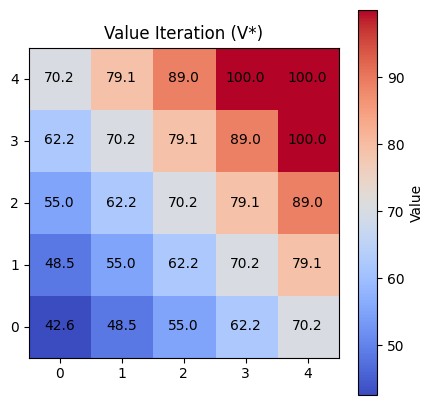

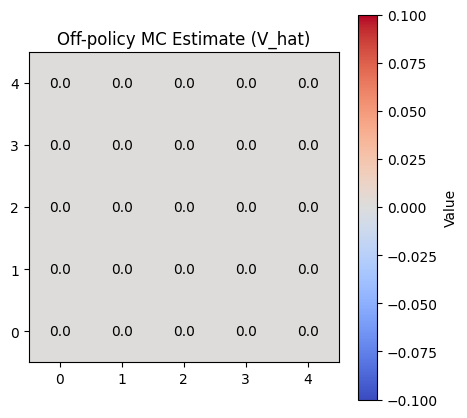

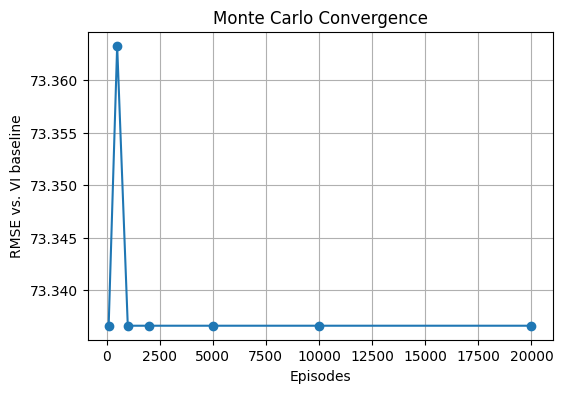

In [11]:
import matplotlib.pyplot as plt
def plot_heatmap(V, title="Value Function"):
    """
    Visualize a value function as a heatmap with numeric values in each cell.
    """
    grid = np.array([[V[(i,j)] for j in range(n)] for i in range(n)])
    
    plt.figure(figsize=(5,5))
    plt.imshow(grid, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)
    
    # Annotate each cell with its value
    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{grid[i,j]:.1f}", ha="center", va="center", color="black")
    
    plt.gca().invert_yaxis()  # keep row 0 at the top
    plt.show()

# Plot heatmaps for both VI and MC
plot_heatmap(V_star, "Value Iteration (V*)")
plot_heatmap(V_hat, "Off-policy MC Estimate (V_hat)")


# -------------------------
# 8. RMSE Convergence Plot
# -------------------------

# Collect RMSE over different episode counts
rmse_data = mc_convergence(pi_star)
episodes_list, rmse_list, times_list = zip(*rmse_data)

# Plot convergence curve
plt.figure(figsize=(6,4))
plt.plot(episodes_list, rmse_list, marker='o')
plt.xlabel("Episodes")
plt.ylabel("RMSE vs. VI baseline")
plt.title("Monte Carlo Convergence")
plt.grid(True)
plt.show()